In [327]:
# Run some setup code for this notebook.

import random
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [329]:
# Load the satellite dataset.
tiny_satellite_dir = 'data'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

def get_TINYSAT_data(root_path, split):
    # Get the training dataset!
    split_dir = os.path.join(root_path, split)
    filenames = os.listdir(split_dir)
    filenames = [os.path.join(split_dir, f) for f in filenames if f.endswith('.jpg')] 
    
    labels = [int(os.path.split(f)[-1][0]) for f in filenames]
    images = [np.asarray(Image.open(f).resize((64, 64), Image.BILINEAR)) for f in filenames]
    
    X = np.array(images)
    y = np.array(labels)
    
    return X, y

X_train, y_train = get_TINYSAT_data(tiny_satellite_dir, "train")
X_test, y_test = get_TINYSAT_data(tiny_satellite_dir, "val")

# Save for later analysis
orig_X_train = X_train
orig_X_test = X_test

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Clear previously loaded data.
Training data shape:  (234, 64, 64, 3)
Training labels shape:  (234,)
Test data shape:  (17, 64, 64, 3)
Test labels shape:  (17,)


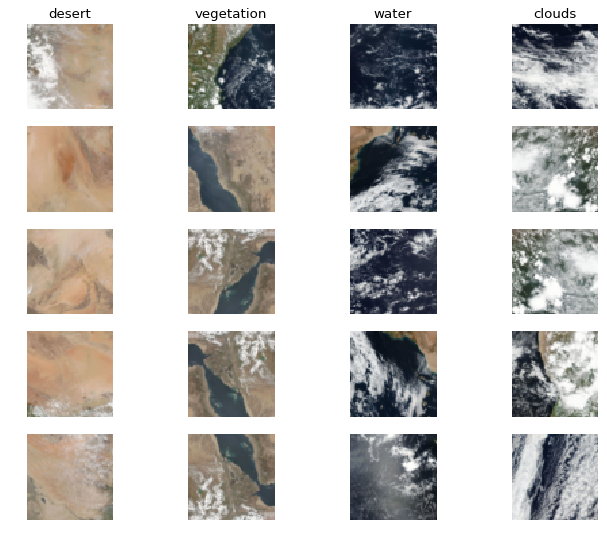

In [330]:
# Visualize some examples from the training dataset.
# We show a few examples of training images from each class.
classes = ['desert', 'vegetation', 'water', 'clouds']
num_classes = len(classes)
samples_per_class = 5
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [331]:
# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(234, 12288) (17, 12288)


[128.50854701 125.34615385 119.14957265 127.68803419 124.65811966
 118.87179487 131.92735043 128.87606838 122.93162393 134.44444444]


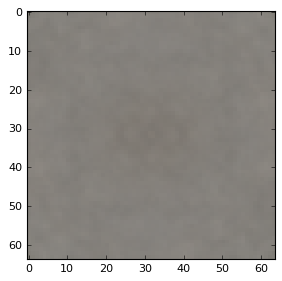

In [332]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((64,64,3)).astype('uint8')) # visualize the mean image
plt.show()

In [333]:
X_train = X_train.astype('float64')
X_test = X_test.astype('float64')

# second: subtract the mean image from train and test data
X_train -= mean_image
X_test -= mean_image

In [334]:
# third: append the bias dimension of ones (i.e. bias trick) so that our linear classifier
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])

print(X_train.shape, X_test.shape)

(234, 12289) (17, 12289)


In [467]:
from models.linear_classifier import LinearSVM
from models.linear_classifier import Softmax
linear_classifier = Softmax() # LinearSVM()
loss_hist = linear_classifier.train(X_train, y_train, learning_rate=1e-7, reg=8e8, 
                      num_iters=1000, verbose=True)

iteration 0 / 1000: loss 19517936.884309
iteration 100 / 1000: loss 19496311.805044
iteration 200 / 1000: loss 19488052.601550
iteration 300 / 1000: loss 19484475.616027
iteration 400 / 1000: loss 19483092.634861
iteration 500 / 1000: loss 19482746.270526
iteration 600 / 1000: loss 19483161.441328
iteration 700 / 1000: loss 19483801.590449
iteration 800 / 1000: loss 19484639.366888
iteration 900 / 1000: loss 19485558.931315


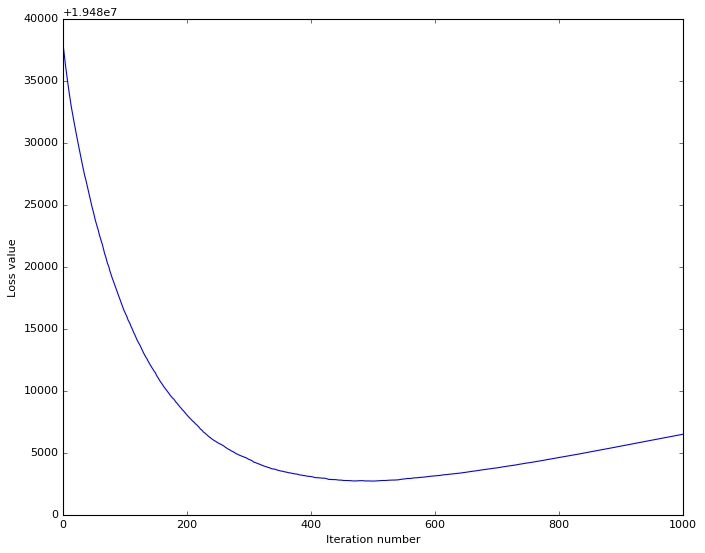

In [468]:
# Plot the loss as a function of iteration number
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [469]:
# Evaluate the performance on both the training and validation set
_, y_train_pred = linear_classifier.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_test_prob, y_test_pred = linear_classifier.predict(X_test)
print('validation accuracy: %f' % (np.mean(y_test == y_test_pred), ))

best_y_test_prob = y_test_prob
best_y_test_pred = y_test_pred
best_classifier = linear_classifier

training accuracy: 0.995726
validation accuracy: 0.823529


In [473]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths
learning_rates = [1e-7, 8e-8, 5e-8]
regularization_strengths = [5e6, 7e7, 8e8, 8e9, 5e10]
# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_y_test_prob = None
best_y_test_pred = None
best_test = -1   # The highest validation accuracy that we have seen so far.
best_classifier = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# Chooses the best hyperparameters by tuning on the validation set.            #
# For each combination of hyperparameters, train a linear classifier on the    #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary.                               #
################################################################################
for learning_rate in learning_rates:
    for regularization_strength in regularization_strengths:
        linear_classifier = Softmax() # LinearSVM
        loss_hist = linear_classifier.train(X_train, y_train, learning_rate=learning_rate, reg=regularization_strength, 
                              num_iters=1000, verbose=False)
        _, y_train_pred = linear_classifier.predict(X_train)
        y_test_prob, y_test_pred = linear_classifier.predict(X_test)
        training_accuracy = np.mean(y_train == y_train_pred)
        test_accuracy = np.mean(y_test == y_test_pred)
        results[(learning_rate, regularization_strength)] = (training_accuracy, test_accuracy)
        if test_accuracy > best_test: 
            best_y_test_prob = y_test_prob
            best_y_test_pred = y_test_pred
            best_test = test_accuracy
            best_classifier = svm
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, test_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f test accuracy: %f' % (
                lr, reg, train_accuracy, test_accuracy))
    
print('best test accuracy achieved during cross-validation: %f' % best_test)

lr 5.000000e-08 reg 5.000000e+06 train accuracy: 0.923077 test accuracy: 0.764706
lr 5.000000e-08 reg 7.000000e+07 train accuracy: 0.948718 test accuracy: 0.588235
lr 5.000000e-08 reg 8.000000e+08 train accuracy: 0.935897 test accuracy: 0.647059
lr 5.000000e-08 reg 8.000000e+09 train accuracy: 0.940171 test accuracy: 0.705882
lr 5.000000e-08 reg 5.000000e+10 train accuracy: 0.923077 test accuracy: 0.588235
lr 8.000000e-08 reg 5.000000e+06 train accuracy: 0.961538 test accuracy: 0.647059
lr 8.000000e-08 reg 7.000000e+07 train accuracy: 0.974359 test accuracy: 0.764706
lr 8.000000e-08 reg 8.000000e+08 train accuracy: 0.987179 test accuracy: 0.588235
lr 8.000000e-08 reg 8.000000e+09 train accuracy: 0.978632 test accuracy: 0.588235
lr 8.000000e-08 reg 5.000000e+10 train accuracy: 0.974359 test accuracy: 0.647059
lr 1.000000e-07 reg 5.000000e+06 train accuracy: 0.982906 test accuracy: 0.764706
lr 1.000000e-07 reg 7.000000e+07 train accuracy: 0.991453 test accuracy: 0.588235
lr 1.000000e-07 

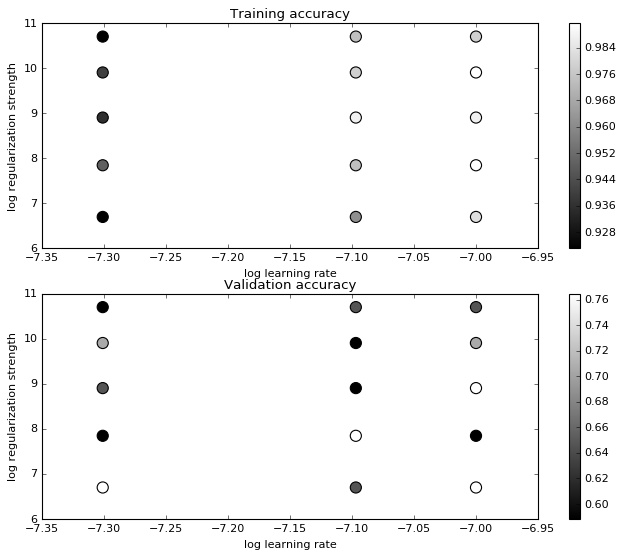

In [474]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('Training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('Validation accuracy')
plt.show()

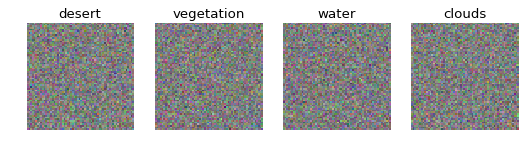

In [479]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_classifier.W[:-1,:] # strip out the bias
w = w.reshape(64, 64, 3, num_classes)
w_min, w_max = np.min(w), np.max(w)
for i in range(num_classes):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

In [480]:
# Generate confusion matrix
# - results = list of tuples of (correct label, predicted label)
# - categories = list of category names
# Returns confusion matrix; rows are correct labels and columns are predictions
def confusion_matrix(results, categories, plotConfusion=False):
    # Empty confusion matrix
    matrix = np.zeros((len(categories),len(categories)))

    # Iterate over all labels and populate matrix
    for label, pred in results:
        matrix[label, pred] += 1

    # Print matrix and percent accuracy
    accuracy = float(np.trace(matrix)) * 100.0 / len(results)
    print('Accuracy: ' +  str(accuracy) + '%')

    # Normalize confusion matrix
    normalizeMatrix = True
    if normalizeMatrix:
      print("Non-normalized conf_matrix:")
      print(matrix)
      s = np.sum(matrix,1) # Sum each row
      for i in range(matrix.shape[0]):
        # Normalization handles class imbalance in training set
        matrix[i,:] /= s[i]

    # Save matrix to file:
    # np.save("confusion_matrix.npy",matrix)

    # Plot the confusion matrix
    if plotConfusion:
        plot_confusion_matrix(matrix, categories)

def plot_confusion_matrix(cm, names=None, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(4)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    # Add labels to confusion matrix:
    if names is None:
        names = range(cm.shape[0])

    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)

    plt.tight_layout()
    plt.ylabel('Correct label')
    plt.xlabel('Predicted label')
    plt.show()

Accuracy: 76.4705882353%
Non-normalized conf_matrix:
[[5. 1. 0. 0.]
 [0. 1. 0. 1.]
 [0. 0. 2. 0.]
 [0. 1. 1. 5.]]


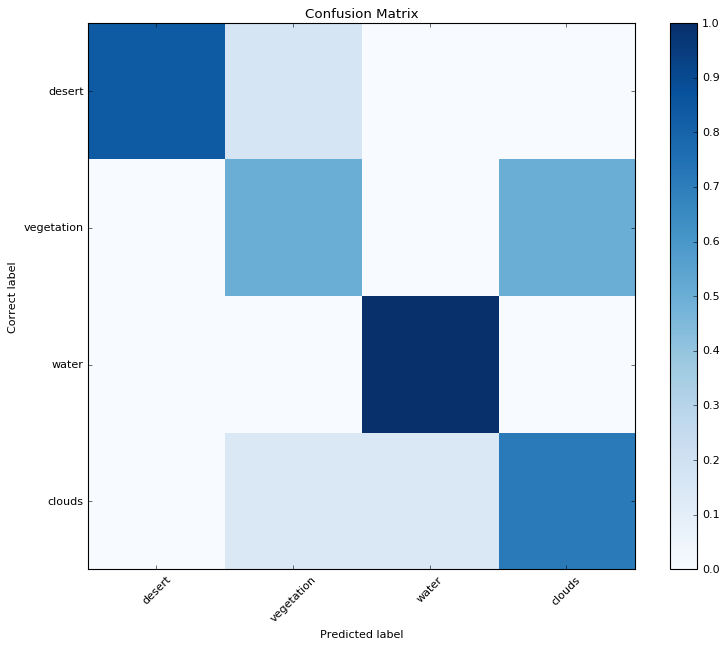

In [481]:
confusion_matrix(zip(y_test, best_y_test_pred), classes, plotConfusion=True)

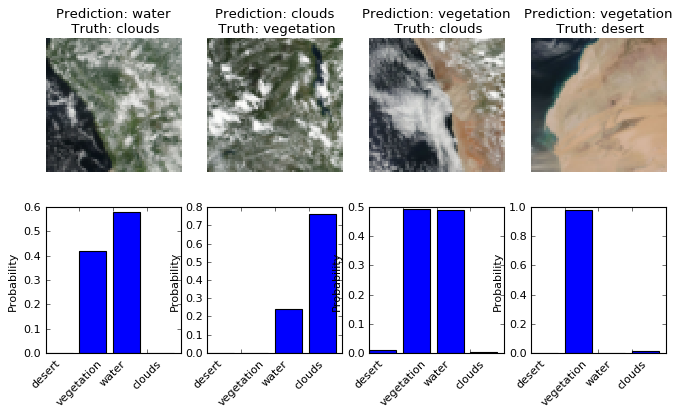

In [482]:
# Visualize misclassified examples from the test dataset.
classes = ['desert', 'vegetation', 'water', 'clouds']
num_classes = len(classes)
max_examples = 4

incorrect_idx = [idx for idx, incorrect in enumerate(y_test != best_y_test_pred) if incorrect]
if len(incorrect_idx) > max_examples:
    incorrect_idx = incorrect_idx[:max_examples]
num_incorrect = len(incorrect_idx)

for y, idx in enumerate(incorrect_idx):
    for i in range(3):
        plt_idx = i * num_incorrect + y + 1
        if i == 0:
            plt.subplot(3, num_incorrect, plt_idx)
            plt.imshow(orig_X_test[idx].astype('uint8'))
            plt.axis('off')
            plt.title("Prediction: %s\n Truth: %s" % (classes[best_y_test_pred[idx]], classes[y_test[idx]]))
        elif i == 1:
            plt.subplot(3, num_incorrect, plt_idx)
            probabilities = best_y_test_prob[idx]
            y_pos = np.arange(len(classes))
            plt.bar(y_pos, probabilities)
            plt.xticks(y_pos, classes, rotation=45)
            plt.ylabel("Probability")
plt.show()